# SAM 40 dataset

**Dataset:** [SAM 40: Dataset](
https://figshare.com/articles/dataset/SAM_40_Dataset_of_40_Subject_EEG_Recordings_to_Monitor_the_Induced-Stress_while_performing_Stroop_Color-Word_Test_Arithmetic_Task_and_Mirror_Image_Recognition_Task/14562090?file=27956376)

**Article:** [SAM 40: Dataset of 40 subject EEG recordings to monitor the induced-stress while performing Stroop color-word test, arithmetic task, and mirror image recognition task](https://www.sciencedirect.com/science/article/pii/S2352340921010465?ref=pdf_download&fr=RR-2&rr=96adf844ce23e918)


Questions:
1. могу ли я сделать видео визуализацию по картинкой головы. То есть чтобы было видео как сигнал меняется со временем по голове.
2. Есть ли какая-то проверка на линейнную зависимость каналов


MNE continuous data working

# Import libraries


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
plt.ion()


import mne
mne.set_log_level('error')


import os
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.options.display.max_columns = None # показываем все колонки

# Reading files

In [2]:
def load_sam40_file(file_path):

    eeg_channels = [
        'CZ', 'FZ', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5',
        'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1',
        'PZ', 'OZ', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6',
        'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2'
    ]

    task_to_class = {
        'relax': 'unfocused',
        'stroop': 'focused',
        'arithmetic': 'focused',
        'mirror': 'focused'
    }

    sfreq = 128
    voltage_resolution = 0.51e-6

    mat_data = scipy.io.loadmat(file_path)
    scaled_data = mat_data['Data'] * voltage_resolution

    info = mne.create_info(
        ch_names=eeg_channels,
        sfreq=sfreq,
        ch_types=['eeg'] * len(eeg_channels)
    )
    raw = mne.io.RawArray(scaled_data, info)
    raw.set_montage('standard_1020', match_case=False)

    return raw

In [3]:

data_path = 'datasets//SAM 40 dataset//raw_data//'

raw_objects = []
events = []
metadata = []


task_to_class = {
    'Relax': 1,
    'Stroop': 2,
    'Arithmetic': 3,
    'Mirror_image': 4
}


for task in ['Relax', 'Stroop', 'Arithmetic', 'Mirror_image']:

    for subject in range(1, 41): # 1-40

        for trial in range(1,4): # 1-3


            file_name = f'{task}_sub_{subject}_trial{trial}.mat'
            file_path = os.path.join(data_path, file_name)

            if not os.path.exists(file_path):
                print(f"Файл не найден, пропускаю: {file_name}")
                continue


            # Raw
            raw = load_sam40_file(file_path)
            raw = raw.pick_channels(['F3', 'F4', 'F7', 'F8', 
                                     'FC5', 'FC6', 'O1', 'O2', 
                                     'P7', 'P8', 'T7', 'T8'])
            raw_objects.append(raw)



            # Events
            events_one = mne.make_fixed_length_events(
                raw,
                id=task_to_class[task],
                start=0,
                stop=raw.times[-1],
                duration=0.25,
                overlap=0.0
            )
            events.append(events_one)


            # Metadata
            meta_one = pd.DataFrame({
                "subject": [f'subject_{subject}'] * len(events_one),
                "session": [f'trial_{trial}'] * len(events_one)
            })
            metadata.append(meta_one)


# Raw
raw_objects = [raw_objects[0].copy()] + raw_objects[1:]
first_samps = [r.first_samp for r in raw_objects]
last_samps  = [r.last_samp for r in raw_objects]

sam40_full = mne.concatenate_raws(raw_objects)
del raw_objects

# Events
event_dict = {
    'relax': 1,
    'stroop': 2,
    'arithmetic': 3,
    'mirror': 4
}

events = mne.concatenate_events(events, first_samps, last_samps)

# Metadata
metadata = pd.concat(metadata, ignore_index=True)

# Events plot

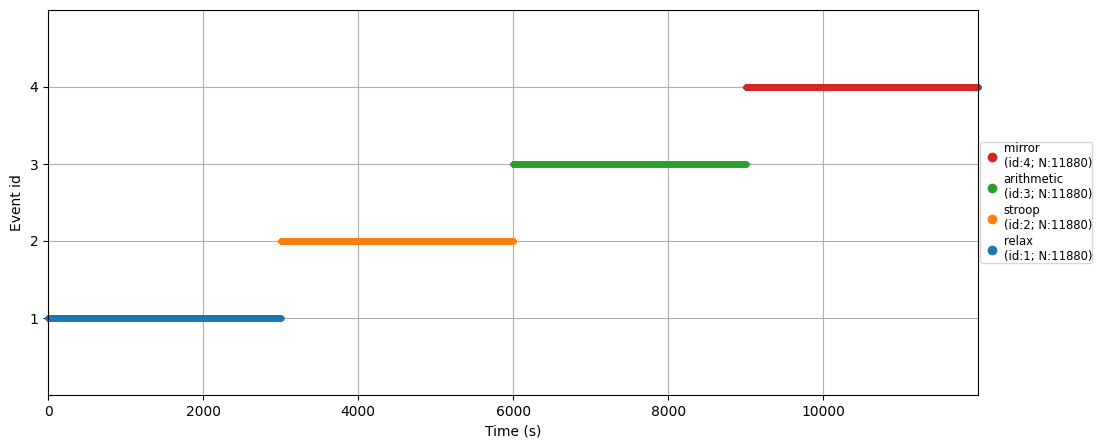

In [4]:

fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(
    events,
    sam40_full.info["sfreq"],
    event_id=event_dict,
    axes=ax
)
plt.show()

# Preprocessing

c:\Users\teacher.dev\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


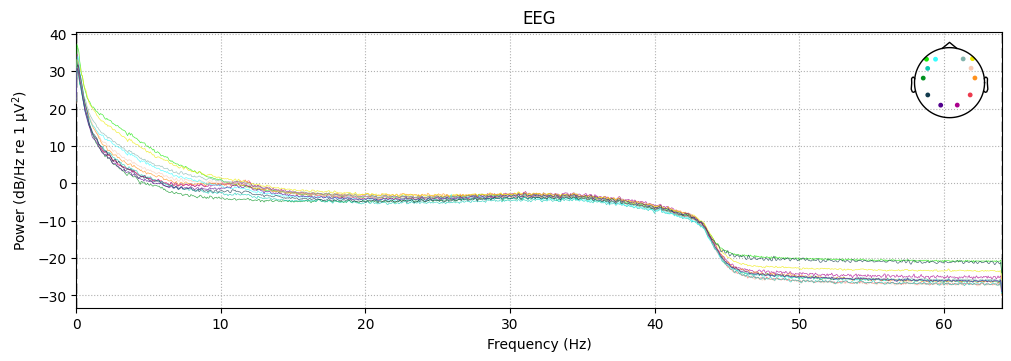

In [5]:
sam40_full.compute_psd().plot();

In [6]:
# Artifact removal with ICA

notch_freqs = [50]
ica_l = 1.0
ica_h = 45.0

raw_for_ica = sam40_full.copy()
raw_for_ica.notch_filter(freqs=notch_freqs) # Notch filter
raw_for_ica.filter(l_freq=ica_l, h_freq=ica_h) # Bandpass filter specially for ICA

ica = mne.preprocessing.ICA(n_components=0.99, random_state=42)
ica.fit(raw_for_ica)

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,25 iterations on raw data (1536000 samples)
ICA components,10
Available PCA components,12
Channel types,eeg
ICA components marked for exclusion,—


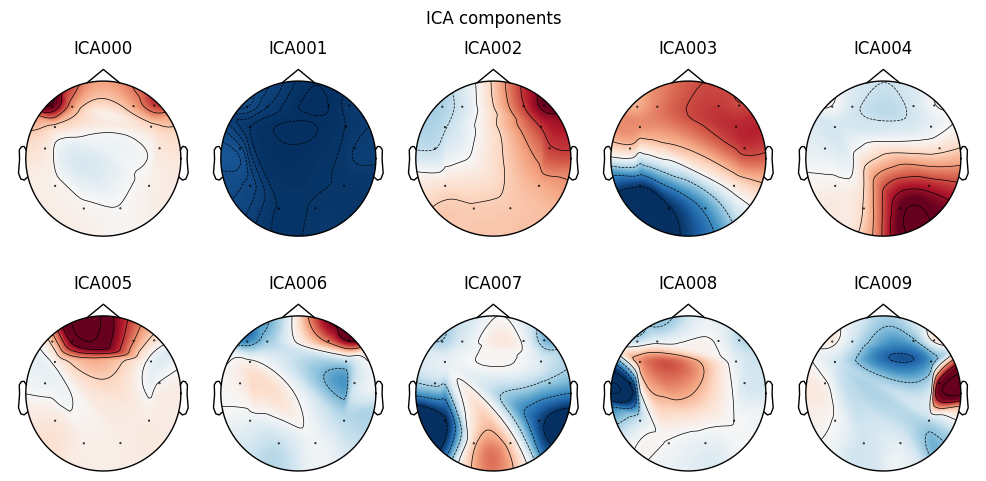

In [7]:
ica.plot_components();

In [8]:
max_ic = 2       # Максимальное число EOG-компонент, которые можно исключить
z_thresh = 2.4   # Начальный Z-порог
z_step = 0.05    # Шаг уменьшения порога

num_excl = 0
final_indices = []

while num_excl < max_ic and z_thresh > 0:
    eog_indices, eog_scores = ica.find_bads_eog(
        raw_for_ica,  # или epochs
        ch_name=['F3', 'F4', 'F7', 'F8'],
        threshold=z_thresh
    )
    num_excl = len(eog_indices)
    final_indices = eog_indices

    if num_excl < max_ic:
        z_thresh -= z_step
    else:
        break

# Назначаем найденные индексы для удаления
ica.exclude = final_indices


# Применяем
ica.apply(sam40_full)

print(f"Final Z-threshold = {z_thresh:.2f}")
print(f"Components to exclude: {ica.exclude}")


Final Z-threshold = 2.05
Components to exclude: [np.int64(0), np.int64(2), np.int64(1)]


In [9]:
# Filtering
final_l = 0.01
final_h  = 43

sam40_full.filter(final_l, final_h)

<RawArray | 12 x 1536000 (12000.0 s), ~140.7 MiB, data loaded>

c:\Users\teacher.dev\AppData\Local\Programs\Python\Python313\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


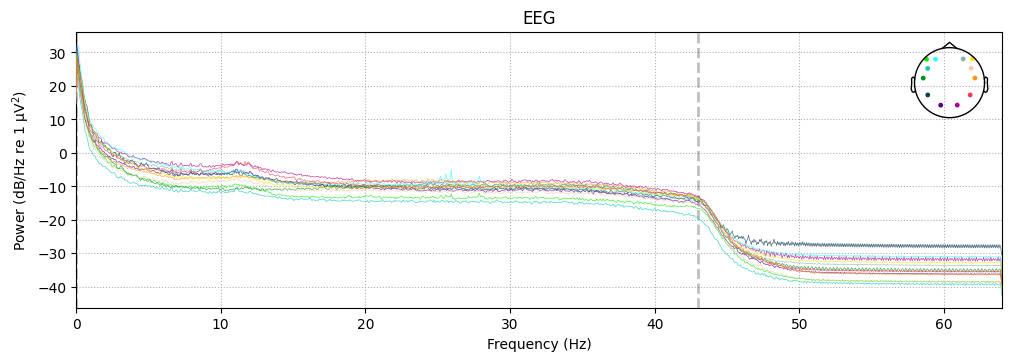

In [10]:
sam40_full.compute_psd().plot();

# Segmentation

In [11]:
merge_dict = {
    'low attention': 0,   # Relax
    'high attention': 1      # Stroop, Arithmetic, Mirror
}

events[:, 2] = np.where(events[:, 2] == 1, 0, 1)

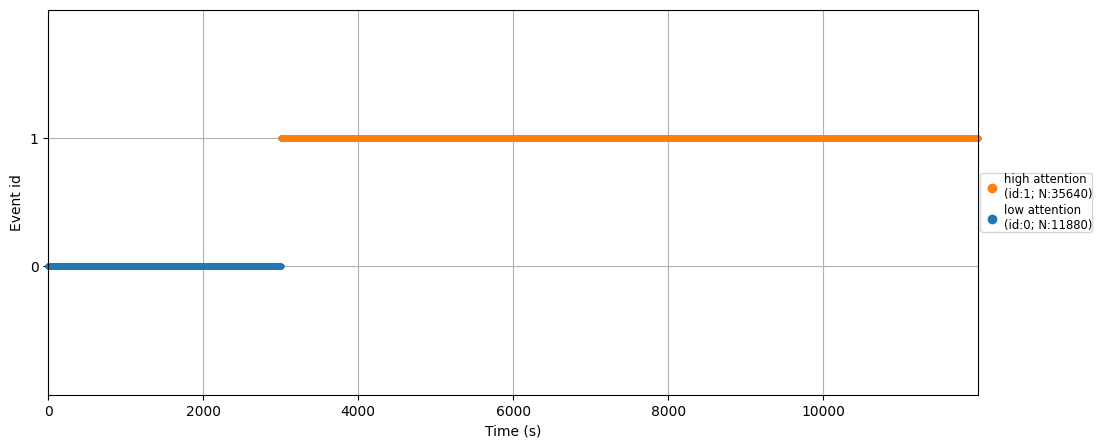

In [12]:

fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(
    events,
    sam40_full.info["sfreq"],
    event_id=merge_dict,
    axes=ax
)
plt.show()

In [13]:
tmin = 0.0
tmax = 1.0



sam40_epochs = mne.Epochs(
    sam40_full,
    events=events,
    event_id=merge_dict,
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    preload=True,
    reject_by_annotation=True,
    metadata=metadata
)


sam40_epochs

<Epochs | 46080 events (all good), 0 – 1 s (baseline off), ~544.2 MiB, data loaded, with metadata,
 'low attention': 11520
 'high attention': 34560>

# Reshaping

In [14]:
# 7. Получаем данные и целевые метки для машинного обучения
X = sam40_epochs.get_data(copy=False) # MEG signals: n_epochs, n_meg_channels, n_times
y = sam40_epochs.events[:, 2]         # target: auditory left vs visual left (в твоем случае это ID событий)


shape = X.shape
n_epochs, n_channels, n_times = X.shape
X = X.reshape(n_epochs, n_channels * n_times)


print(f"X исходная: {shape} (эпохи, каналы, время)")
print(f"X после reshape: {X.shape} (эпохи, признаки)")
print(f"y: {y.shape} (метки классов)")

X исходная: (46080, 12, 129) (эпохи, каналы, время)
X после reshape: (46080, 1548) (эпохи, признаки)
y: (46080,) (метки классов)


# Delete excessive variables

In [15]:
del sam40_full, sam40_epochs, events, metadata, raw_for_ica, ica, 

# Stratified K-Fold Validation

In [16]:
from sklearn.model_selection import StratifiedKFold, cross_val_score,  cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb

In [17]:
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Для бинарной классификации
    n_estimators=100,             # Количество деревьев (можно увеличить)
    learning_rate=0.2,            # Скорость обучения
    max_depth=7,                  # Максимальная глубина дерева (можно настроить)
    eval_metric='logloss',        # Метрика для бинарной классификации
    random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_classifier)
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}


cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)


metrics_table = pd.DataFrame({
    metric: cv_results[f'test_{metric}'] for metric in scoring.keys()
})
metrics_table.loc['mean'] = metrics_table.mean()
metrics_table = metrics_table.round(4)


metrics_table

,accuracy,precision,recall,f1
0,0.8326,0.8339,0.9701,0.8968
1,0.8268,0.8298,0.9676,0.8934
2,0.8330,0.8354,0.9680,0.8969
3,0.8341,0.8342,0.9719,0.8978
4,0.8360,0.8355,0.9729,0.8990
mean,0.8325,0.8338,0.9701,0.8968
